In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### inlezen van data

In [2]:
# eerst laden we de dataset in 
df = pd.read_csv("../3dprinter/data.csv", sep = ';')
X = df.drop('tension_strength', axis = 'columns')
y = df.tension_strength
X.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,elongation
0,0.02,8,90,0,220,60,40,0,0,25,1.2
1,0.02,7,90,1,225,65,40,0,25,32,1.4
2,0.02,1,80,0,230,70,40,0,50,40,0.8
3,0.02,4,70,1,240,75,40,0,75,68,0.5
4,0.02,6,90,0,250,80,40,0,100,92,0.7


### snel een regressie model maken

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# functie om de R2 adjusted te berekenen
def R2adjusted(R2, n, p):
    return 1-(1-R2)*(n-1)/(n-p-1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)
# een lineaire regressie model maken
linreg = LinearRegression()
linreg.fit(x_train, y_train)

y_pred = linreg.predict(x_test)

In [6]:
print('MSE: ', mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)
n = len(y_test)
p = len(x_test.columns)
R2adj = R2adjusted(R2, n, p)
print('R2: ', R2)
print('R2adj', R2adj)

MSE:  60.551737423014465
R2:  0.01188418043383721
R2adj -0.8242138207375311


Zoals we zien is de R2 erg slecht. We kunnen de correlatie coefficienten berekenen om te kijken of we last hebben van multicollineariteit.

In [7]:
# maakt de correlatie matrix
X.corr()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,elongation
layer_height,1.000000e+00,-0.192571,3.498560e-03,-4.353849e-18,8.332953e-16,1.024570e-15,-5.550085e-02,8.707699e-17,-1.103383e-16,0.801341,0.507583
wall_thickness,-1.925714e-01,1.000000,1.025762e-01,1.451594e-01,-1.184929e-01,-2.932662e-02,-4.195307e-01,1.175100e-01,-2.932662e-02,-0.226987,0.176364
infill_density,3.498560e-03,0.102576,1.000000e+00,-1.672736e-01,2.386137e-01,-2.337202e-16,-9.430408e-02,-2.628585e-01,3.841975e-17,0.118389,0.159009
infill_pattern,-4.353849e-18,0.145159,-1.672736e-01,1.000000e+00,-1.703995e-01,4.019437e-17,-1.208658e-17,2.000000e-01,-1.205831e-17,-0.068340,0.046138
nozzle_temperature,8.332953e-16,-0.118493,2.386137e-01,-1.703995e-01,1.000000e+00,6.024534e-01,-5.901839e-16,-7.838379e-01,6.024534e-01,0.348611,-0.527447
bed_temperature,1.024570e-15,-0.029327,-2.337202e-16,4.019437e-17,6.024534e-01,1.000000e+00,9.681476e-16,1.406803e-16,1.000000e+00,0.192142,-0.300871
print_speed,-5.550085e-02,-0.419531,-9.430408e-02,-1.208658e-17,-5.901839e-16,9.681476e-16,1.000000e+00,-3.867705e-17,-1.312743e-17,0.121066,-0.234052
material,8.707699e-17,0.117510,-2.628585e-01,2.000000e-01,-7.838379e-01,1.406803e-16,-3.867705e-17,1.000000e+00,-4.019437e-18,-0.233173,0.394737
fan_speed,-1.103383e-16,-0.029327,3.841975e-17,-1.205831e-17,6.024534e-01,1.000000e+00,-1.312743e-17,-4.019437e-18,1.000000e+00,0.192142,-0.300871
roughness,8.013409e-01,-0.226987,1.183890e-01,-6.834030e-02,3.486108e-01,1.921416e-01,1.210657e-01,-2.331730e-01,1.921416e-01,1.000000,0.098962


Hoge correlaties die we kunnen vinden zijn bed temperature met fan speed, tension strength met elongation, roughness met layer height. We kunnen even wat eruit filteren door te kijken welke (absolute) correlaties hoger zijn dan 0.4.

In [8]:
X.corr()[abs(X.corr())>0.4]

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,elongation
layer_height,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.801341,0.507583
wall_thickness,NaN,1.000000,NaN,NaN,NaN,NaN,-0.419531,NaN,NaN,NaN,NaN
infill_density,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
infill_pattern,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nozzle_temperature,NaN,NaN,NaN,NaN,1.000000,0.602453,NaN,-0.783838,0.602453,NaN,-0.527447
bed_temperature,NaN,NaN,NaN,NaN,0.602453,1.000000,NaN,NaN,1.000000,NaN,NaN
print_speed,NaN,-0.419531,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
material,NaN,NaN,NaN,NaN,-0.783838,NaN,NaN,1.000000,NaN,NaN,NaN
fan_speed,NaN,NaN,NaN,NaN,0.602453,1.000000,NaN,NaN,1.000000,NaN,NaN
roughness,0.801341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN


We kunnen de vif test doen om te kijken welke correlaties het hoogst zijn.

In [9]:
# we kunnen de join functie gebruiken om een list van strings aan elkaar te verbinden met ' + ' als seperator
print(X.columns)
' + '.join(list(X.columns))

Index(['layer_height', 'wall_thickness', 'infill_density', 'infill_pattern',
       'nozzle_temperature', 'bed_temperature', 'print_speed', 'material',
       'fan_speed', 'roughness', 'elongation'],
      dtype='object')


'layer_height + wall_thickness + infill_density + infill_pattern + nozzle_temperature + bed_temperature + print_speed + material + fan_speed + roughness + elongation'

### Uitvoeren van VIF test

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from patsy import dmatrices 

# het eerste argument in dmatrices is 'y ~ X1 + X2 + ... '. Hier moet je y en X vervangen door de kolomnamen van je dataframe
y_vif, x_vif = dmatrices('tension_strength ~ ' + ' + '.join(list(X.columns)), data=df, return_type='dataframe') 

vif = pd.DataFrame() 
vif['variable'] = x_vif.columns 
vif['VIF'] = [variance_inflation_factor(x_vif.values, i) for i in range(x_vif.shape[1])]
vif

,variable,VIF
0,Intercept,0.000000
1,layer_height,9.135254
2,wall_thickness,1.483681
3,infill_density,1.551519
4,infill_pattern,1.093557
5,nozzle_temperature,93.229213
6,bed_temperature,inf
7,print_speed,1.568547
8,material,48.882993
9,fan_speed,inf


We zien hoge vif waardes. Dat betekent dat we wat kolommen moeten verwijderen. Probeer een aantal kolommen te verwijderen zodat alle vif waardes lager dan 5 zijn.

### iteratief variabelen verwijderen voor betere R2adjusted

In [11]:
X = df.drop(['tension_strength', 'fan_speed', 'bed_temperature', 'nozzle_temperature'], axis = 'columns')

In [12]:
# het eerste argument in dmatrices is 'y ~ X1 + X2 + ... '. Hier moet je y en X vervangen door de kolomnamen van je dataframe
y_vif, x_vif = dmatrices('tension_strength ~ ' + ' + '.join(list(X.columns)), data=df, return_type='dataframe') 

vif = pd.DataFrame() 
vif['variable'] = x_vif.columns 
vif['VIF'] = [variance_inflation_factor(x_vif.values, i) for i in range(x_vif.shape[1])]
vif

,variable,VIF
0,Intercept,27.826660
1,layer_height,7.770976
2,wall_thickness,1.464904
3,infill_density,1.422072
4,infill_pattern,1.090303
5,print_speed,1.381724
6,material,1.554674
7,roughness,5.533300
8,elongation,3.227075


Sommige waarden zijn nog steeds erg hoog, zoals layer_height

In [13]:
X = df.drop(['tension_strength', 'fan_speed', 'bed_temperature', 'nozzle_temperature', 'layer_height'], axis = 'columns')

In [14]:
# laten we eerst de data standardiseren
Z = (X-X.mean())/X.std()

In [15]:
# we can make a new train/test split
x_train, x_test, y_train, y_test = train_test_split(Z, y, test_size=0.5, random_state=2)

In [16]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)

In [17]:
print('MSE: ', mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)
n = len(y_test)
p = len(x_test.columns)
R2adj = R2adjusted(R2, n, p)
print('R2: ', R2)
print('R2adj', R2adj)

MSE:  17.345946104566018
R2:  0.71693952179233
R2adj 0.6003852072362306


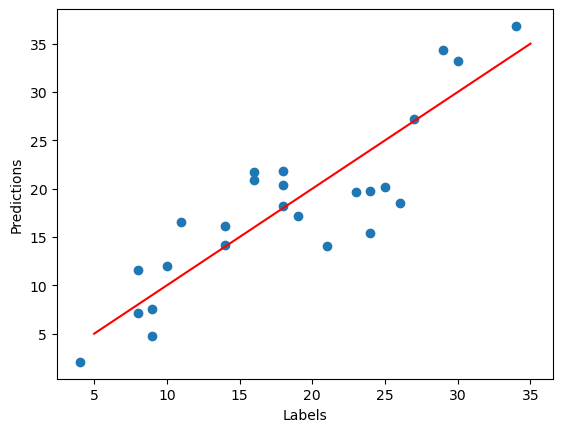

In [18]:
plt.scatter(y_test, y_pred)
plt.plot([5, 35], [5, 35], 'r')

plt.xlabel('Labels')
plt.ylabel('Predictions')

plt.show()

<BarContainer object of 7 artists>

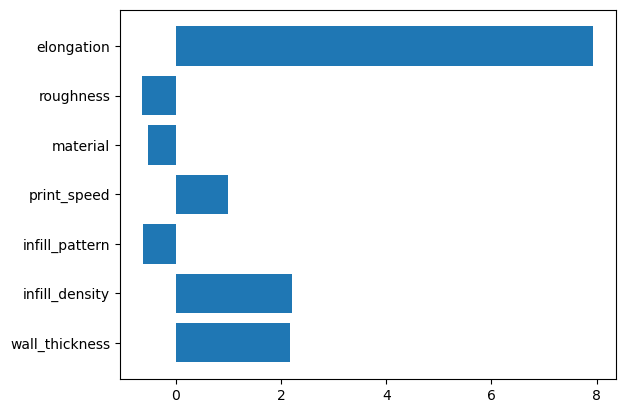

In [19]:
plt.barh(X.columns, linreg.coef_)

We can see that material does not add a lot of 'predictiveness'. We can remove that column

In [20]:
# preprocess data
X = df.drop(['tension_strength', 'fan_speed', 'material', 'layer_height', 'nozzle_temperature', 
             'bed_temperature'], axis = 'columns')
Z = (X-X.mean())/X.std()
x_train, x_test, y_train, y_test = train_test_split(Z, y, test_size=0.5, random_state=2)

# make a linear regression model
linreg = LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)

# calculate metrics
R2 = r2_score(y_test, y_pred)
n = len(y_test)
p = len(x_test.columns)
R2adj = R2adjusted(R2, n, p)
print('R2: ', R2)
print('R2adj', R2adj)

R2:  0.731431340373359
R2adj 0.6419084538311453


We see a small increase in the R2adj. That is very good. How about the beta's?

<BarContainer object of 6 artists>

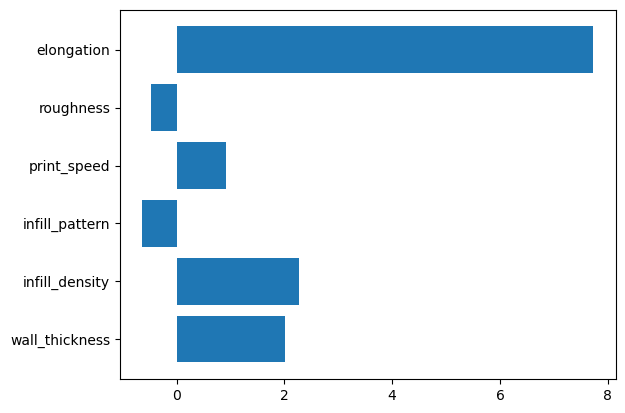

In [21]:
plt.barh(X.columns, linreg.coef_)

Roughness doesn't add a lot. We can also remove those

In [22]:
# preprocess data
X = df.drop(['tension_strength', 'fan_speed', 'material', 'layer_height', 'nozzle_temperature', 
             'bed_temperature', 'roughness'], axis = 'columns')
Z = (X-X.mean())/X.std()
x_train, x_test, y_train, y_test = train_test_split(Z, y, test_size=0.5, random_state=2)

# make a linear regression model
linreg = LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)

# calculate metrics
R2 = r2_score(y_test, y_pred)
n = len(y_test)
p = len(x_test.columns)
R2adj = R2adjusted(R2, n, p)
print('R2: ', R2)
print('R2adj', R2adj)

R2:  0.743884023847998
R2adj 0.6764850827553659


Now we see both a increase in the R2 and R2adj. Can you try to make this model better by removing more columns?